# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

Импортируем нужные для исследования библиотеки

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.shape

(7591, 2)

In [4]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Как видно из таблиц выше, выборка содержит 7591 изображение, тип данных соответствует *object* для названий файлов и *int64* для реального возраста, что говорит о том, что загрузка таблицы прошла корректно и признаки имеют необходимые типы данных.

Также в данных видно сильное стандартное отклонение **(std > 17)**, что так же может негативно сказаться на итоговых показателях модели.

Посмотрим на график распределения возраста

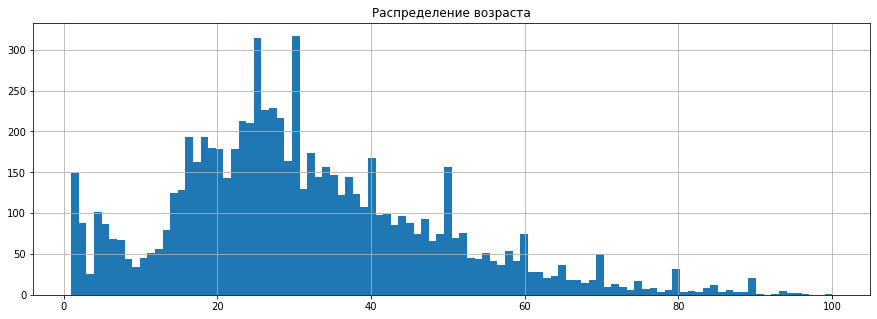

In [6]:
labels['real_age'].hist(bins=100, figsize=(15, 5))
plt.title('Распределение возраста')
plt.show()

Распределение возраста имеет смещение вправо, а так же присутствует пик около значения "0", что может повлиять на итоговые показатели модели

Посмотрим на устройство датасета

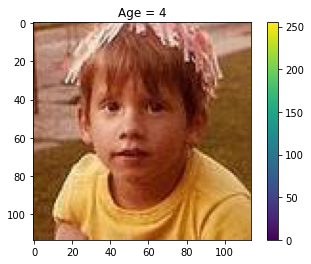

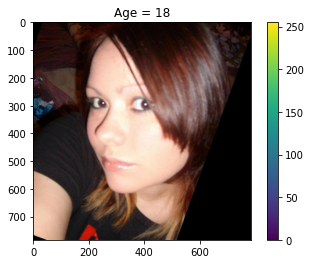

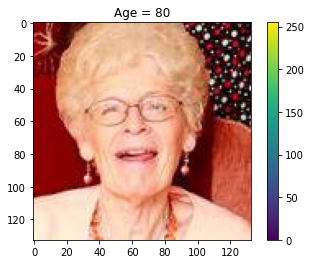

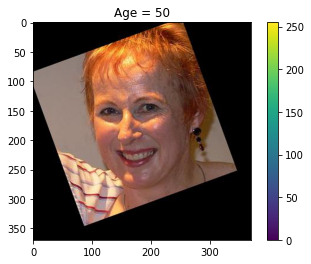

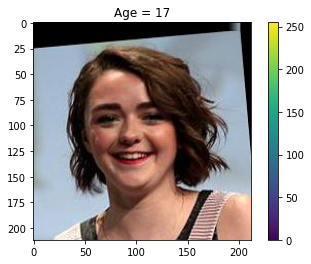

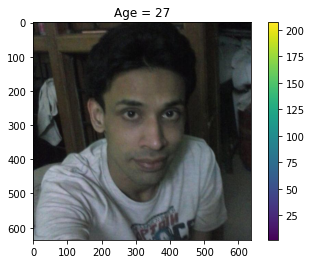

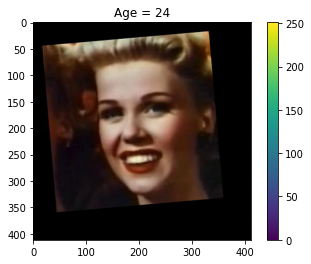

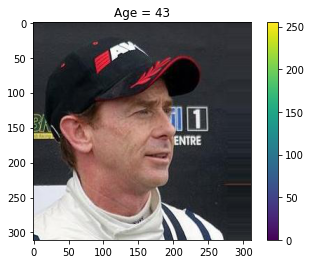

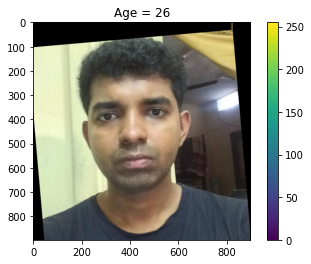

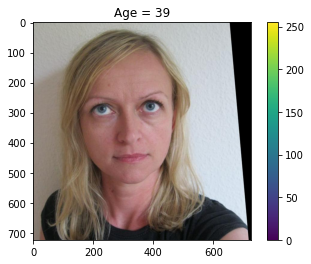

In [10]:
for i in range(10):
    image = Image.open('/datasets/faces/final_files/00000' + str(i) +'.jpg')
    image_array = np.array(image)
    plt.imshow(image_array)
    plt.colorbar()
    plt.title('Age = ' + str(labels['real_age'][i]))
    plt.show()

В фотографиях из датасета уже имеются приобразования в виде поворотов фотографий, потому не придется усложнять ImageDataGenerator

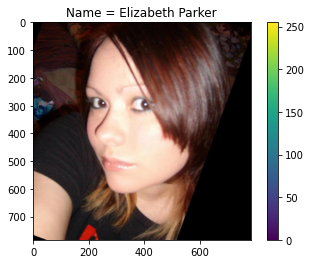

In [7]:
image = Image.open('/datasets/faces/final_files/000001.jpg')
image_array = np.array(image)
plt.imshow(image_array)
plt.colorbar()
plt.title('Name = ' + str(labels['real_name'][1]))
plt.show()

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25,
                                 rescale=1/255.)
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_datagen_flow

def load_test(path):
    datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1/255.)
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow


def create_model(input_shape):
    optimizer = Adam(lr=.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=3,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model


```

```
Train for 356 steps, validate for 119 steps
Epoch 1/3
2023-05-15 10:17:56.336413: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-05-15 10:17:56.642690: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 51s - loss: 227.6392 - mae: 10.9427 - val_loss: 404.5569 - val_mae: 15.1284
Epoch 2/3
356/356 - 42s - loss: 68.7582 - mae: 6.4005 - val_loss: 162.0119 - val_mae: 9.4839
Epoch 3/3
356/356 - 41s - loss: 38.8725 - mae: 4.7881 - val_loss: 100.2204 - val_mae: 7.8321
119/119 - 10s - loss: 100.2204 - mae: 7.8321
Test MAE: 7.8321
```

## Анализ обученной модели

Удалось обучить нейронную модель на основе архитектуры **ResNet50** на 3 эпохах, добавив в нее выходной полносвязный слой с одним нейроном и функцией активации **ReLU**, итоговый показатель метрики качества которой **MAE** составил ~7.83 на тестовой выборке.

Возможные причины ухудшения качества модели:
- В исходных данных было сильное стандартное отклонение **(std > 17)**, что негативно сказалось на итоговых показателях модели.
- Распределение возраста имеет смещение вправо, а так же присутствует пик около значения "0", что также повлияло на итоговые показатели модели.

В ходе исследования были проделаны следующие шаги:
- Загружен и проведен исследовательский анализ исходных данных
- Написана нейронная модель на основе архитектуры ResNet50 с добавлением полносвязного выходного слоя с одним нейроном и функцией активации ReLU
- Проведен анализ обученной модели